# GLODAP Test set
This notebook downloads GLODAPv2 data from the web and then saves the data as .csv file.
[CbSyst](https://github.com/oscarbranson/cbsyst) is used to estimate pCO2 using T,S,pressure, phos, and silicate.

The data is gridded to a 1x1 monthly grid, using the same routine as [Gregor et al. 2019](https://www.geosci-model-dev-discuss.net/gmd-2019-46/). 
Script was obtained froma personal communication with Luke Gregor.

Old notes : https://chris35wills.github.io/gridding_data/


In [12]:
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import cmocean as cm
import matplotlib.pyplot as plt
from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot

# Analysis tools
import GLODAP
import obs_to_model

## Process GLODAP
This uses the same method used in Gregor et al. 2019. Script provided courtesy of Luke Gregor

In [ ]:
# Downloads GLODAP if you do not not already have it 
GLODAP.get_GLODAP() #Junfu- might need to update the *py with this updated data: https://glodap.info/index.php/merged-and-adjusted-data-product-v2-2023/

# Define the surface depth of the data
surface_depth = 10

# Date range to create monthly mask over
date_range = ['1982-01','2018-12']

# Observations directory
dir_obs='/local/data/artemis/observations'

# Process the data, calculate spco2
gd_sub = GLODAP.process_GLODAP(fl='./GLODAPv2_pH_DIC_ALK_subset.csv', surface_depth=surface_depth)

# Convert data into series 
ds_gd = pd.Series({'time':gd_sub.index, 
                   'lon':gd_sub.lon.values,
                   'lat':gd_sub.lat.values,
                   'spco2':gd_sub.spco2.values})

# Generate monthly mask
xda = obs_to_model.create_monthly_mask(dates=['1982-01','2018-12'])

# Perform the matching using a function L. Gregor wrote
out = obs_to_model.match_ungridded_to_gridded(variable=ds_gd.spco2, 
                           time=ds_gd.time, 
                           lat=ds_gd.lat, 
                           lon=ds_gd.lon, 
                           xda=xda.transpose('time','lat','lon'))

# rename variables
out = out.rename({'out_mean':'spco2_mean', 'out_std':'spco2_std'})

print('Done!!')

In [2]:
# Save data
out.to_netcdf(f'{dir_obs}/GLODAP_v2/processed/GLODAPv2_spco2_1x1_198201-201812.nc')

# Test plot

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<Figure size 612x792 with 0 Axes>

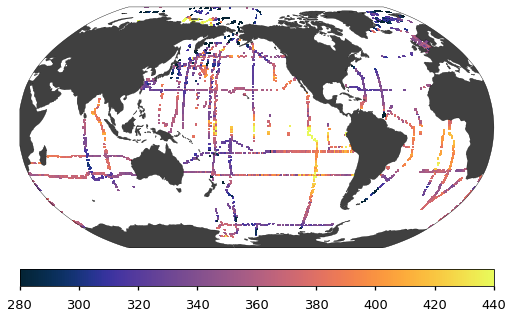

In [13]:
## colorbar [min, max, step]
vrange = [280, 440, 20]
cmap = cm.cm.thermal

with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(8.5,11))  
    
    ### Mask
    dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
    sub = dia.add_plot(lat = out['lat'], 
                       lon = out['lon'], 
                       data = out['spco2_mean'].mean('time'), 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=0)
    dia.add_colorbar(sub)
    #plt.pcolor(ds_out['lon'], ds['lat'], ds_out['spco2'].mean('time'), vmin=280, vmax=440, cmap=cm.cm.thermal)
    #plt.colorbar()
